## Deep Learning to find the response of a Ballistic Composite

#### Imports needed for DL and handling of data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#### Reading of CSV file with all pre-calculated data for composites

In [2]:
composites_data = pd.read_csv("../../data/all_data_2.csv")
#Drop columns that have the same value for all composites (they don't give any information)
nunique = composites_data.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
composites_data.drop(cols_to_drop, axis=1, inplace=True)
composites_data.head()

,L1_h,L1_E,L1_rho,L2_h,L4_h,L6_h,L9_h,Y
0,5.137523,3.340000e+11,3690,0.514014,0.514014,0.514014,1.012914,1
1,5.137523,3.340000e+11,3690,0.514014,0.514014,0.514014,2.011149,1
2,5.137523,3.340000e+11,3690,0.514014,0.514014,0.514014,3.009383,0
3,5.137523,3.340000e+11,3690,0.514014,0.514014,0.541067,1.012914,1
4,5.137523,3.340000e+11,3690,0.514014,0.514014,0.541067,2.011149,1


In [3]:
#Drop some rows to have approximately equal amount of true and false values
comp1 = composites_data[composites_data["Y"] == 1]
comp1 = comp1.sample(frac=0.35, random_state=123)
comp2 = composites_data[composites_data["Y"] == 0]
composites_data = pd.concat([comp1, comp2])
print(composites_data.shape)

(3420, 8)


#### Pre-processing of data and definition of the Model to train

In [4]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.regularizers import l1

#Split data into training and testing data
train_data = composites_data.sample(frac=0.7, random_state=123)
test_data = composites_data.drop(train_data.index)

#As all data is numeric, we can create a numpy array for all the x features (to make the operations faster) and we 
#can manually create the label y vector
def get_numpy(data):
    data_features = data.copy()
    data_labels = np.array(data_features.pop('Y'))
    data_features = np.array(data_features)
    return data_features, data_labels

comp_features_train, comp_labels_train = get_numpy(train_data)
comp_features_test, comp_labels_test = get_numpy(test_data)

#As every column doesn't have the same range and scale, it's useful to normalize the data using the Normalization layer
#provided by the keras.utils module
comp_features_train = normalize(comp_features_train, axis=0)
comp_features_test = normalize(comp_features_test, axis=0)

#Number of True and False labels in the Test set
print("Percentage of true labels: ",np.sum(comp_labels_test)/len(comp_labels_test))
print("Percentage of false labels: ",np.sum(comp_labels_test == 0)/len(comp_labels_test))

Percentage of true labels:  0.4727095516569201
Percentage of false labels:  0.5272904483430799


In [11]:
## NN MODEL
composites_model = tf.keras.Sequential([
    layers.Dense(256, input_shape=(comp_features_train.shape[1],), activation="relu", kernel_regularizer=l1(1e-4)),
    layers.Dense(128, activation="relu", kernel_regularizer=l1(1e-4)),
    layers.Dense(64, activation="relu", kernel_regularizer=l1(1e-4)),
    layers.Dense(32, activation="relu", kernel_regularizer=l1(1e-4)),
    layers.Dense(2, activation="softmax")
])

opt = Adam(learning_rate=0.0003)
composites_model.compile(loss = "sparse_categorical_crossentropy",
                           optimizer = opt, metrics=["accuracy"])
composites_model.summary()

# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.999):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 66        
Total params: 45,346
Trainable params: 45,346
Non-trainable params: 0
_________________________________________________________________


#### Model fit with training data

In [12]:
#For training, 20 epochs will be used and callback is used to stop training when a given accuracy is reached (99.9%)
callbacks = myCallback()
history = composites_model.fit(comp_features_train, comp_labels_train, epochs=50, batch_size=16, 
                               validation_batch_size=32, callbacks=[callbacks], 
                               validation_data=(comp_features_test, comp_labels_test))

Epoch 1/50
150/150 [==============================] - 1s 2ms/step - loss: 0.9645 - accuracy: 0.6102 - val_loss: 0.8470 - val_accuracy: 0.4727
Epoch 2/50
150/150 [==============================] - 0s 1ms/step - loss: 0.8167 - accuracy: 0.5715 - val_loss: 0.7077 - val_accuracy: 0.9493
Epoch 3/50
150/150 [==============================] - 0s 1ms/step - loss: 0.6780 - accuracy: 0.7926 - val_loss: 0.4927 - val_accuracy: 0.7427
Epoch 4/50
150/150 [==============================] - 0s 1ms/step - loss: 0.3811 - accuracy: 0.9349 - val_loss: 0.4635 - val_accuracy: 0.7456
Epoch 5/50
150/150 [==============================] - 0s 1ms/step - loss: 0.2653 - accuracy: 0.9504 - val_loss: 0.3527 - val_accuracy: 0.9493
Epoch 6/50
150/150 [==============================] - 0s 1ms/step - loss: 0.2485 - accuracy: 0.9501 - val_loss: 0.7023 - val_accuracy: 0.7427
Epoch 7/50
150/150 [==============================] - 0s 1ms/step - loss: 0.2191 - accuracy: 0.9593 - val_loss: 0.3333 - val_accuracy: 0.9493
Epoch 

In [13]:
y = composites_model.predict(comp_features_test)
print(y)

[[0.005 0.995]
 [0.    1.   ]
 [0.964 0.036]
 ...
 [0.963 0.037]
 [0.962 0.038]
 [0.958 0.042]]


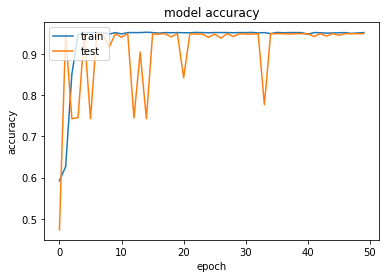

In [14]:
#Plot history of model!
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()